In [1]:
import torch

from transformers import AutoModelForCausalLM, pipeline, GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

import numpy as np
import sympy as sp
import json

In [2]:
from model.tokens import Token, TOKEN_TYPE_EXPRESSIONS, TOKEN_TYPE_ANSWERS
from model.equation_interpreter import Equation
from model.vocabulary import Vocabulary
from model.tokens import Token

In [3]:
from datasets import disable_caching
disable_caching()

In [4]:
# Create a combined vocabulary
vocabulary = Vocabulary.construct_from_list(TOKEN_TYPE_EXPRESSIONS + TOKEN_TYPE_ANSWERS)

# Global variables
model_name = "JustSumAI"
project_name = "JustSumAI"
repo_name = f"{model_name}_cleaned_gpt2_data"

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

input_text = "This is my input sequence."
input_ids = tokenizer.encode(input_text, return_tensors='pt')
input_ids, input_ids.size()

(tensor([[1212,  318,  616, 5128, 8379,   13]]), torch.Size([1, 6]))

In [6]:
vocabulary.end_seq_index

47

# Load model

In [7]:
model = GPT2LMHeadModel.from_pretrained(f"Dragonoverlord3000/{model_name}", force_download=True)
model

C:\Users\Hugo\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hugo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50, bias=False)
)

In [8]:
test_example_ids = torch.LongTensor([vocabulary.vectorize(["#", "/", "0", "0"])[:-1] + [vocabulary.separator_index]])
test_example_ids[0], test_example_ids.size()

(tensor([46, 22, 21, 10, 10, 49]), torch.Size([1, 6]))

In [9]:
test = model(test_example_ids).logits
print(test.size())
[vocabulary.getToken(torch.argmax(o).item()) for o in test[0]]

torch.Size([1, 6, 50])


['TT_ONE', 'TT_INTEGER', '/', '0', '0', 'TT_INTEGER']

In [10]:
out = model.generate(test_example_ids, 
                     eos_token_id=vocabulary.end_seq_index, 
                     pad_token_id=vocabulary.mask_index)
out, out.size()

C:\Users\Hugo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (43) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


(tensor([[46, 22, 21, 10, 10, 49, 31, 31, 43, 47]]), torch.Size([1, 10]))

In [11]:
l = [vocabulary.getToken(o.item()) for o in out[0]]
l, l.index("[SEP]")

(['<BEGIN>',
  '#',
  '/',
  '0',
  '0',
  '[SEP]',
  'TT_INTEGER',
  'TT_INTEGER',
  'TT_DIVIDE',
  '<END>'],
 5)

In [12]:
eq = Equation([Token(vocabulary.getToken(o.item())) for o in out[0]][l.index("[SEP]")+1:-1], notation="postfix")
eq.tokenized_equation

[---- Type: TT_INTEGER 	 Value: None ----,
 ---- Type: TT_INTEGER 	 Value: None ----,
 ---- Type: TT_DIVIDE 	 Value: None ----]

In [13]:
eq.getMathmetaicalNotation()

'(Z/Z)'

______

In [14]:
sp.parse_expr(eq.getMathmetaicalNotation(), evaluate=False)

Z/Z

# Embedding Weights

In [15]:
word_embeddings = model.transformer.wte.weight  # Word Token Embeddings 
position_embeddings = model.transformer.wpe.weight  # Word Position Embeddings 

In [16]:
word_embeddings, word_embeddings.shape

(Parameter containing:
 tensor([[-0.0189,  0.0423,  0.0188,  ...,  0.0423, -0.0622,  0.0062],
         [-0.0610, -0.0131, -0.0101,  ..., -0.0196, -0.0220,  0.0336],
         [-0.0760, -0.0263, -0.0124,  ..., -0.0584, -0.0182,  0.0206],
         ...,
         [ 0.0944,  0.0669, -0.0911,  ...,  0.0516,  0.0287, -0.0211],
         [-0.0197,  0.0430,  0.0198,  ...,  0.0424, -0.0629,  0.0081],
         [-0.0060,  0.0681,  0.0519,  ..., -0.0300, -0.1502,  0.0249]],
        requires_grad=True),
 torch.Size([50, 768]))

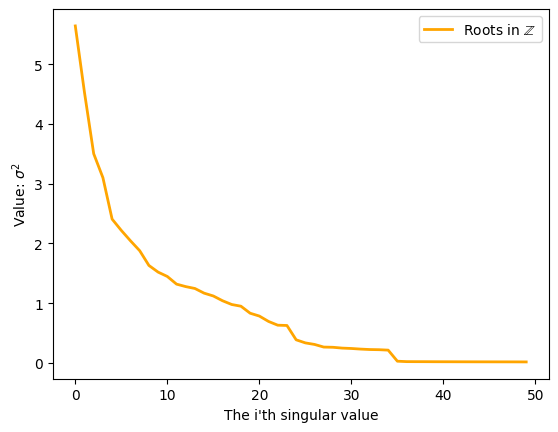

In [17]:
U,D,V = np.linalg.svd(word_embeddings.detach().numpy())
plt.xlabel("The i'th singular value")
plt.ylabel(r"Value: $\sigma^2$")
plt.plot(D, color="orange", linewidth=2)
plt.legend(["Roots in $\mathbb{Z}$"])

In [18]:
# with open("Qwordembeds.txt", "w") as f:
#     f.write(json.dumps(word_embeddings.detach().numpy().tolist()))
# f.close()

### Accept user input

In [19]:
from IPython.display import display
import ipywidgets as widgets

In [20]:
numerator_degree = 3
denominator_degree = 6

In [21]:
def parentherizer(val):
    if "-" in val:
        return f"({val})"
    return val

In [22]:
math_display = widgets.HTMLMath(
    value=f"Sum Math",
    placeholder='',
    description='',
)

numerator_list = [widgets.SelectionSlider(
    options=TOKEN_TYPE_EXPRESSIONS[:-2],
    value='-5',
    description=f'Root {i+1}',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
) for i in range(numerator_degree)]

denominator_list = [
    widgets.SelectionSlider(
    options=TOKEN_TYPE_EXPRESSIONS[:-2],
    value='-5',
    description=f'Root {i+1}',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
) for i in range(denominator_degree)]

ui_1 = widgets.VBox(numerator_list)
ui_2 = widgets.VBox(denominator_list)

def f(**kwargs):
#     print(kwargs, list(kwargs))
    sum_str = r"$$\sum_{n=1}^{\infty}\frac{" + "".join([f"(n - {parentherizer(kwargs[str(i)])})" for i in range(numerator_degree)]) + "}{" + "".join([f"(n - {parentherizer(kwargs[str(i + numerator_degree)])})" for i in range(denominator_degree)]) + "}" + "$$"
    math_display.value = sum_str
    display(math_display)

out = widgets.interactive(f, **{str(i):v for i,v in enumerate(numerator_list + denominator_list)})

display(out)#ui_1, ui_2, out)

interactive(children=(SelectionSlider(continuous_update=False, description='Root 1', index=5, options=('-10', …

In [23]:
[v.value for v in numerator_list]

['-5', '-5', '-5']

In [24]:
input_sum = vocabulary.vectorize(
    [v.value for v in numerator_list] + ["/"] + [v.value for v in denominator_list]
)[:-1] + [vocabulary.separator_index]
input_sum = torch.LongTensor([input_sum])
out = model.generate(input_sum,
                    eos_token_id=vocabulary.end_seq_index, 
                    pad_token_id=vocabulary.mask_index)
pred = [vocabulary.getToken(o.item()) for o in out[0]]
pred

['<BEGIN>',
 '-5',
 '-5',
 '-5',
 '/',
 '-5',
 '-5',
 '-5',
 '-5',
 '-5',
 '-5',
 '[SEP]',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_PI',
 'TT_INTEGER',
 'TT_POW',
 'TT_MULTIPLY',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 '<END>']

In [25]:
eq = Equation([Token(p) for p in pred][pred.index("[SEP]")+1:-1], notation="postfix")
eq.getMathmetaicalNotation()

'((Z-(Z*(Pi^Z)))/Z)'